In [504]:
import numpy as np
from plotnine import *
import pandas as pd

In [505]:
results = pd.read_csv("benchmark_results.csv", sep='\t')

In [506]:
nbse_info = pd.read_csv("nbse_sets.csv")

In [507]:
data = results.merge(nbse_info, left_on=['name'], right_on=['set_name'])
data['mcs_size_to_atom_size'] = data['mcs_atoms'] / data['avg_atoms']
data = data.query('local_similarity > 0 and took < 900')
data.set_index(['name', 'optimizer_steps', 'optimizer_fine', 'optimizer_coarse',
                'num_conformers', 'core', 'assemblies'])

,,,,,,,took,local_similarity,avg_conformer_tanimoto_dist,siena_rmsd,divide,set_name,most_atoms,most_bonds,least_atoms,least_bonds,mcs_atoms,num_mols,avg_atoms,mcs_bonds,avg_atoms_to_mcs,mcs_size_to_atom_size
name,optimizer_steps,optimizer_fine,optimizer_coarse,num_conformers,core,assemblies,,,,,,,,,,,,,,,,
3ke8,100,0.01,0.3,40,mcs,10,18,0.664895,0.629946,2.792387,True,3ke8,17,17,12,11,11,17,14.647,NaN,75.10%,0.751007
2vke,100,0.01,0.3,40,mcs,10,218,0.653470,0.613581,2.697748,True,2vke,42,45,31,34,22,12,33.522,NaN,65.63%,0.656285
1odn,100,0.01,0.3,40,mcs,10,303,0.569305,0.657672,3.152543,True,1odn,30,29,18,17,15,28,24.251,NaN,61.85%,0.618531
4dko,100,0.01,0.3,40,mcs,10,43,0.579109,0.458960,4.240663,True,4dko,30,33,23,24,15,13,26.077,NaN,57.52%,0.575220
3qqs,100,0.01,0.3,40,mcs,10,48,0.619915,0.311268,5.187691,True,3qqs,29,31,10,10,8,19,14.789,NaN,54.09%,0.540943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1qss,100,0.01,0.5,60,mcs,1,389,0.420050,0.725896,6.024546,True,1qss,69,70,27,28,19,21,36.019,NaN,52.75%,0.527499
4ajn,100,0.01,0.5,60,mcs,1,338,0.399431,0.497132,7.012849,True,4ajn,44,48,12,13,5,12,25.333,NaN,19.74%,0.197371
2zsd,100,0.01,0.5,60,mcs,1,128,0.297835,0.643812,6.986309,True,2zsd,52,54,27,29,10,12,34.417,NaN,29.06%,0.290554


In [508]:
data[data.name == '4ajn']

,name,took,local_similarity,avg_conformer_tanimoto_dist,siena_rmsd,optimizer_coarse,optimizer_fine,num_conformers,assemblies,divide,...,most_atoms,most_bonds,least_atoms,least_bonds,mcs_atoms,num_mols,avg_atoms,mcs_bonds,avg_atoms_to_mcs,mcs_size_to_atom_size
285,4ajn,338,0.399431,0.497132,7.012849,0.5,0.01,60,1,True,...,44,48,12,13,5,12,25.333,NaN,19.74%,0.197371


In [509]:
data.describe()

,took,local_similarity,avg_conformer_tanimoto_dist,siena_rmsd,optimizer_coarse,optimizer_fine,num_conformers,assemblies,optimizer_steps,most_atoms,most_bonds,least_atoms,least_bonds,mcs_atoms,num_mols,avg_atoms,mcs_bonds,mcs_size_to_atom_size
count,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.0,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,0.0,288.000000
mean,132.996528,0.516474,0.472100,4.123133,0.434028,0.044444,26.493056,6.875000,100.0,31.996528,34.579861,15.496528,16.166667,9.461806,17.118056,22.902826,NaN,0.414105
std,122.976429,0.098066,0.111162,1.416124,0.094196,0.061290,15.746023,4.292242,0.0,9.018950,9.999680,5.077105,5.790777,3.720917,6.203850,5.792425,NaN,0.115883
min,1.000000,0.297835,0.174775,1.647598,0.300000,0.010000,10.000000,1.000000,100.0,12.000000,12.000000,9.000000,9.000000,4.000000,12.000000,10.769000,NaN,0.197371
25%,42.750000,0.447115,0.392778,2.913379,0.300000,0.010000,20.000000,1.000000,100.0,26.750000,29.000000,11.750000,11.750000,7.000000,13.000000,19.210500,NaN,0.318590
50%,102.000000,0.521924,0.481347,3.970395,0.500000,0.010000,20.000000,10.000000,100.0,30.000000,32.500000,14.000000,15.000000,9.000000,15.000000,22.315500,NaN,0.375834
75%,187.250000,0.598536,0.539353,5.195686,0.500000,0.050000,30.000000,10.000000,100.0,37.000000,41.000000,18.000000,20.000000,11.000000,19.000000,26.077000,NaN,0.475160
max,865.000000,0.719335,0.737755,8.482188,0.500000,0.200000,60.000000,10.000000,100.0,73.000000,80.000000,31.000000,34.000000,22.000000,40.000000,37.294000,NaN,0.751007


In [510]:
metric_cols = ['siena_rmsd', 'avg_conformer_tanimoto_dist',
               'local_similarity']

program_parameters = ['assemblies', 'num_conformers', 'optimizer_coarse',
                      'optimizer_fine', 'optimizer_steps']

set_props = [str(c) for c in nbse_info.columns] + ['mcs_size_to_atom_size']

def lookup_de_name(s: str) -> str:
    name_lookup_de = {
        'name': 'Name',
        'took': 'Laufzeit',
        'siena_rmsd': 'SIENA RMSD',
        'avg_conformer_tanimoto_dist': 'Konformer Distanz',
        'local_similarity': 'Lokale Ähnlichkeit',
        'most_atoms': 'Meiste Atome',
        'least_atoms': 'Kleinste Atome',
        'most_bonds': 'Meiste Bindungen',
        'least_bonds': 'Wenigste Bindungen',
        'num_mols': 'Menge Moleküle',
        'avg_atoms': 'Durschn. Atome',
        'mcs_atoms': 'Größe MCS',
        'mcs_size_to_atom_size': 'MCS / Durchschn. Atome',
        'optimizer_coarse': 'Optimizer Coarse',
        'optimizer_fine': 'Optimizer Fine',
        'optimizer_steps': 'Optimizer Steps',
        'num_conformers': 'Konformere',
        'assemblies': 'Assemblies'
    }
    
    if s in name_lookup_de:
        return name_lookup_de[s]
    else:
        return s


In [511]:
metrics = data.drop(columns=['set_name', 'name', 'divide', 'core', 'mcs_bonds',
                             'avg_atoms_to_mcs'])
metrics.var()

took                           15123.202078
local_similarity                   0.009617
avg_conformer_tanimoto_dist        0.012357
siena_rmsd                         2.005408
optimizer_coarse                   0.008873
optimizer_fine                     0.003756
num_conformers                   247.937234
assemblies                        18.423345
optimizer_steps                    0.000000
most_atoms                        81.341451
most_bonds                        99.993600
least_atoms                       25.776991
least_bonds                       33.533101
mcs_atoms                         13.845226
num_mols                          38.487756
avg_atoms                         33.552188
mcs_size_to_atom_size              0.013429
dtype: float64

In [512]:
metrics.head()

,took,local_similarity,avg_conformer_tanimoto_dist,siena_rmsd,optimizer_coarse,optimizer_fine,num_conformers,assemblies,optimizer_steps,most_atoms,most_bonds,least_atoms,least_bonds,mcs_atoms,num_mols,avg_atoms,mcs_size_to_atom_size
0,18,0.664895,0.629946,2.792387,0.3,0.01,40,10,100,17,17,12,11,11,17,14.647,0.751007
1,218,0.653470,0.613581,2.697748,0.3,0.01,40,10,100,42,45,31,34,22,12,33.522,0.656285
2,303,0.569305,0.657672,3.152543,0.3,0.01,40,10,100,30,29,18,17,15,28,24.251,0.618531
3,43,0.579109,0.458960,4.240663,0.3,0.01,40,10,100,30,33,23,24,15,13,26.077,0.575220
4,48,0.619915,0.311268,5.187691,0.3,0.01,40,10,100,29,31,10,10,8,19,14.789,0.540943


In [513]:
metrics.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
took,288.0,132.996528,122.976429,1.000000,42.750000,102.000000,187.250000,865.000000
local_similarity,288.0,0.516474,0.098066,0.297835,0.447115,0.521924,0.598536,0.719335
avg_conformer_tanimoto_dist,288.0,0.472100,0.111162,0.174775,0.392778,0.481347,0.539353,0.737755
siena_rmsd,288.0,4.123133,1.416124,1.647598,2.913379,3.970395,5.195686,8.482188
optimizer_coarse,288.0,0.434028,0.094196,0.300000,0.300000,0.500000,0.500000,0.500000
optimizer_fine,288.0,0.044444,0.061290,0.010000,0.010000,0.010000,0.050000,0.200000
num_conformers,288.0,26.493056,15.746023,10.000000,20.000000,20.000000,30.000000,60.000000
assemblies,288.0,6.875000,4.292242,1.000000,1.000000,10.000000,10.000000,10.000000
optimizer_steps,288.0,100.000000,0.000000,100.000000,100.000000,100.000000,100.000000,100.000000
most_atoms,288.0,31.996528,9.018950,12.000000,26.750000,30.000000,37.000000,73.000000


In [514]:
correlation = 'spearman'
correlations = metrics.corr(method=correlation)

In [515]:
corr = correlations.stack().reset_index()
corr.columns = ['var1', 'var2', 'val']
corr_config = corr.loc[corr['var2'].isin(metric_cols)]
corr_config = corr_config.loc[corr['var1'].isin(set_props)]
corr_config = corr_config.round({'val': 3})

corr_config['var1'] = corr_config['var1'].map(lookup_de_name)
corr_config['var2'] = corr_config['var2'].map(lookup_de_name)


In [516]:
corr

,var1,var2,val
0,took,took,1.000000
1,took,local_similarity,-0.369609
2,took,avg_conformer_tanimoto_dist,0.076838
3,took,siena_rmsd,0.268844
4,took,optimizer_coarse,-0.124368
...,...,...,...
251,mcs_size_to_atom_size,least_bonds,0.005280
252,mcs_size_to_atom_size,mcs_atoms,0.639315
253,mcs_size_to_atom_size,num_mols,0.054101
254,mcs_size_to_atom_size,avg_atoms,-0.062769


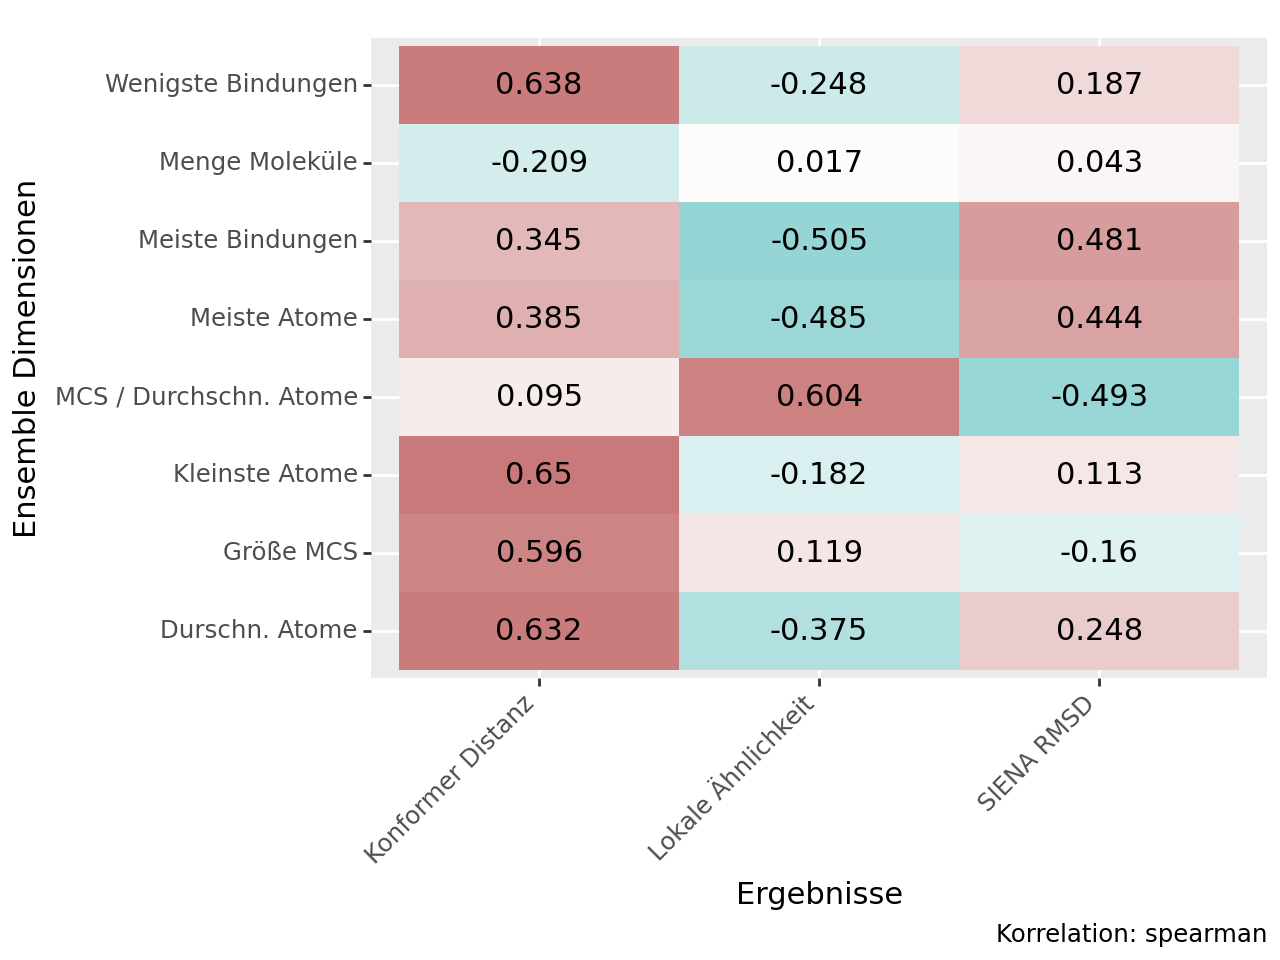

<Figure Size: (640 x 480)>

In [517]:
(ggplot(corr_config, mapping=aes('var2', 'var1', fill='val', label='val'))
 + geom_tile()
 + scale_fill_gradient2(low='#79c9c9', high='#C97979', guide=False)
 + theme(axis_text_x=element_text(rotation=45, hjust=1))
 + geom_text()
 + labs(x='Ergebnisse', y='Ensemble Dimensionen', caption='Korrelation: {}'.format(correlation))
 )

In [518]:
corr_metrics = corr[
    corr['var1'].isin(metric_cols) & corr['var2'].isin(metric_cols)]
corr_metrics = corr_metrics.round({'val': 3})

corr_metrics['var1'] = corr_metrics['var1'].map(lookup_de_name)
corr_metrics['var2'] = corr_metrics['var2'].map(lookup_de_name)


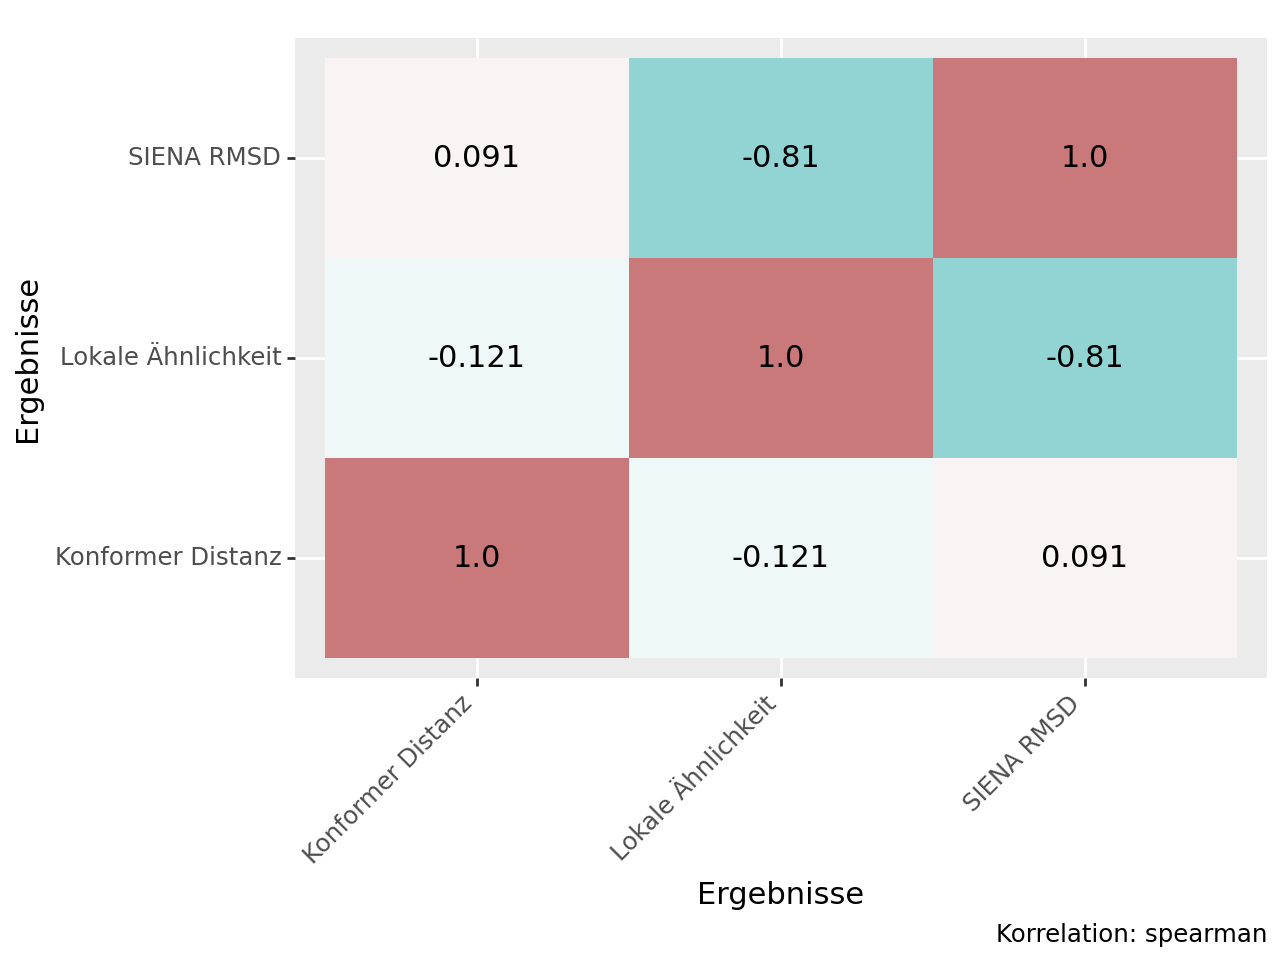

<Figure Size: (640 x 480)>

In [519]:
(ggplot(corr_metrics, mapping=aes('var1', 'var2', fill='val', label='val'))
 + geom_tile()
 + scale_fill_gradient2(low='#79c9c9', high='#C97979', guide=False)
 + theme(axis_text_x=element_text(rotation=45, hjust=1))
 + geom_text()
 + labs(x='Ergebnisse', y='Ergebnisse', caption='Korrelation: {}'.format(correlation))
 )

In [520]:
corr_options = corr[
    corr['var1'].isin(program_parameters) & corr['var2'].isin(metric_cols)]
corr_options = corr_options.round({'val': 3})
corr_options['var1'] = corr_options['var1'].map(lookup_de_name)
corr_options['var2'] = corr_options['var2'].map(lookup_de_name)


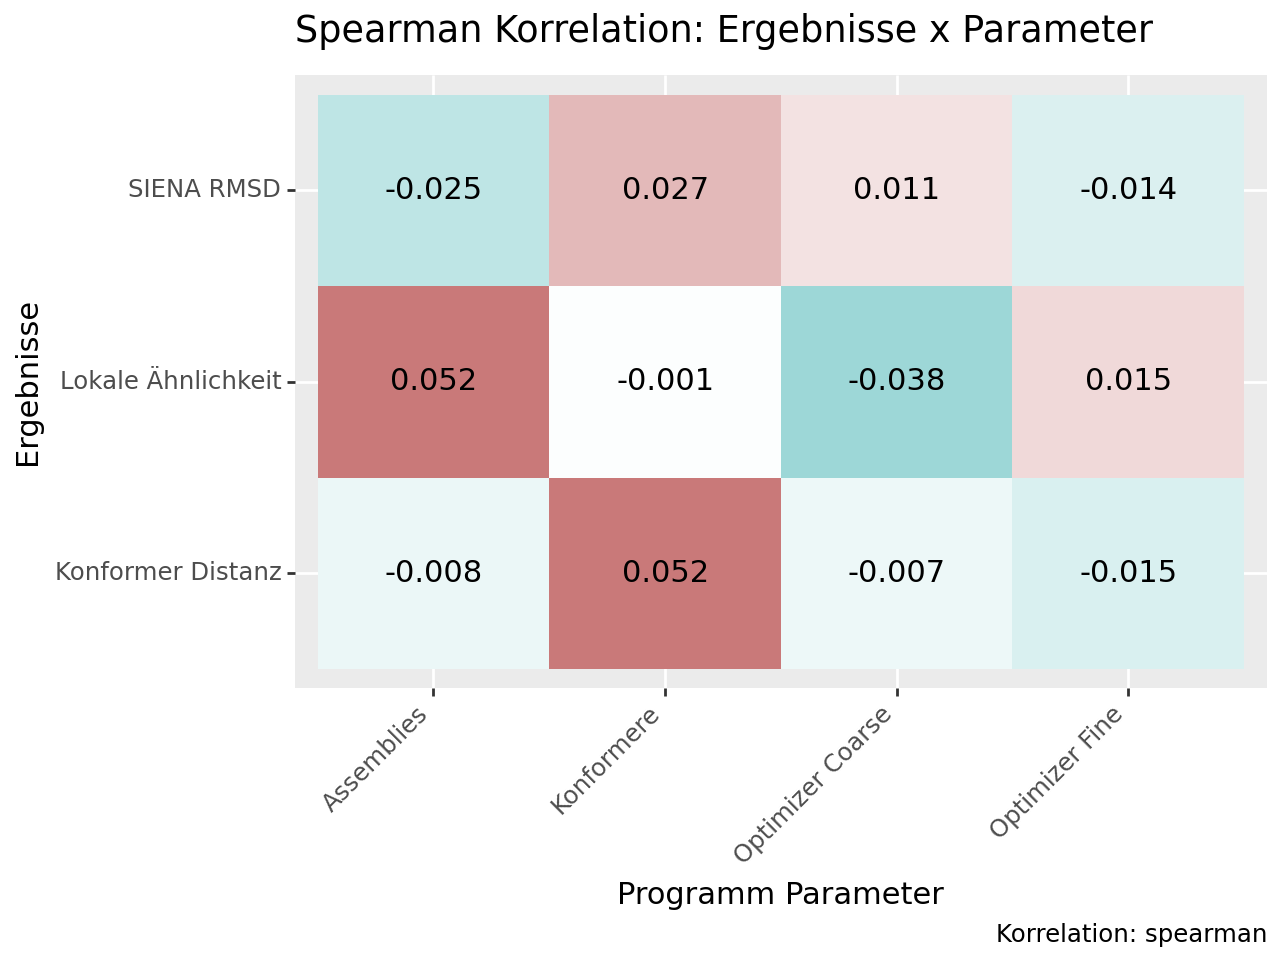

<Figure Size: (640 x 480)>

In [521]:
(ggplot(corr_options, mapping=aes('var1', 'var2', fill='val', label='val'))
 + ggtitle("Spearman Korrelation: Ergebnisse x Parameter")
 + geom_tile()
 + scale_fill_gradient2(low='#79c9c9', high='#C97979', guide=False)
 + theme(axis_text_x=element_text(rotation=45, hjust=1))
 + geom_text()
 + labs(x='Programm Parameter', y='Ergebnisse',caption='Korrelation: {}'.format(correlation))
 )


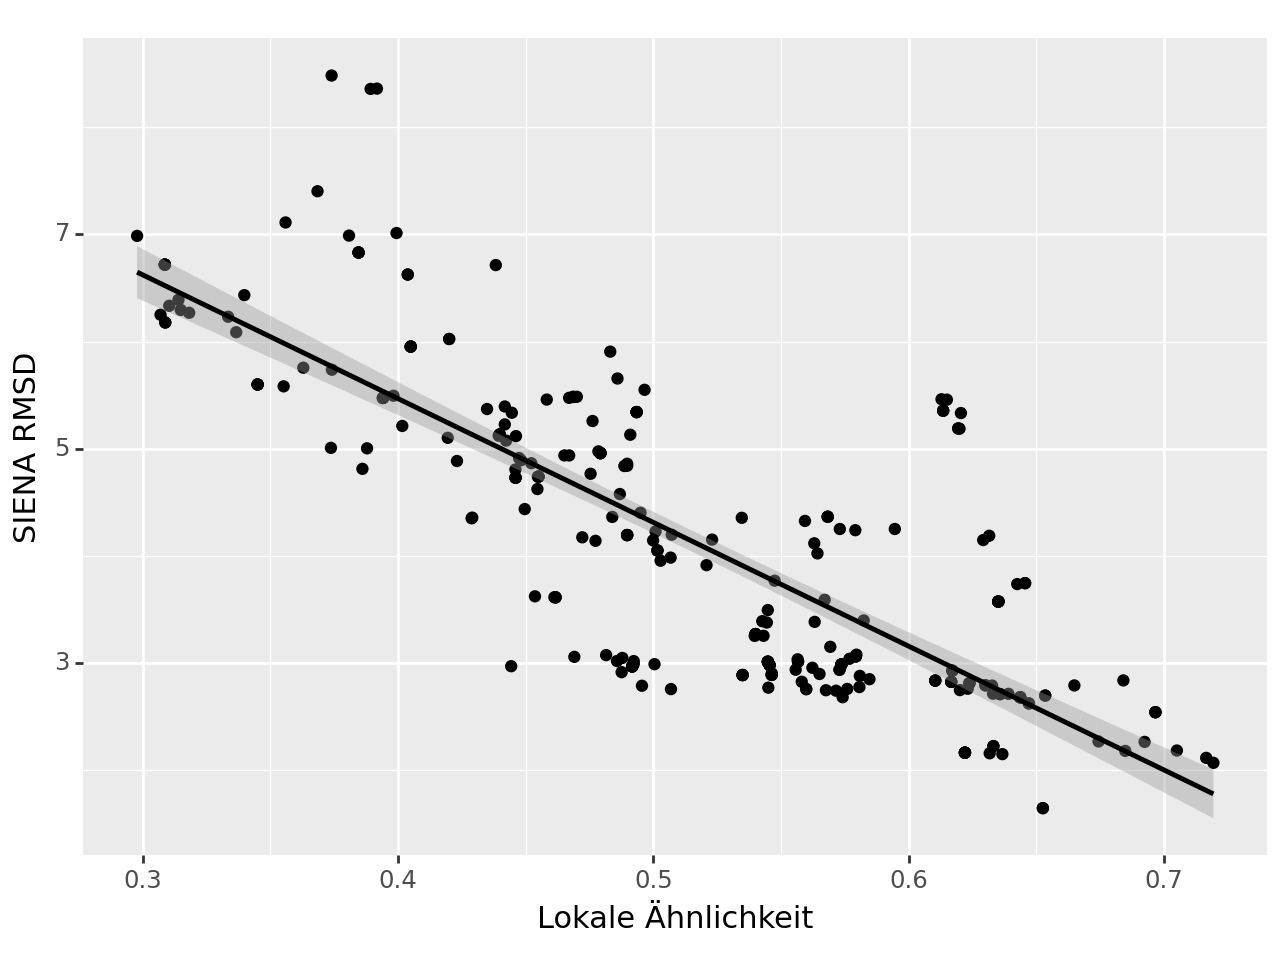

<Figure Size: (640 x 480)>

In [522]:
(ggplot(data=data, mapping=aes(x='local_similarity', y='siena_rmsd'))
 + geom_point()
 + geom_smooth(method='lm')
 + labs(x=lookup_de_name('local_similarity'), y=lookup_de_name('siena_rmsd'))
 )

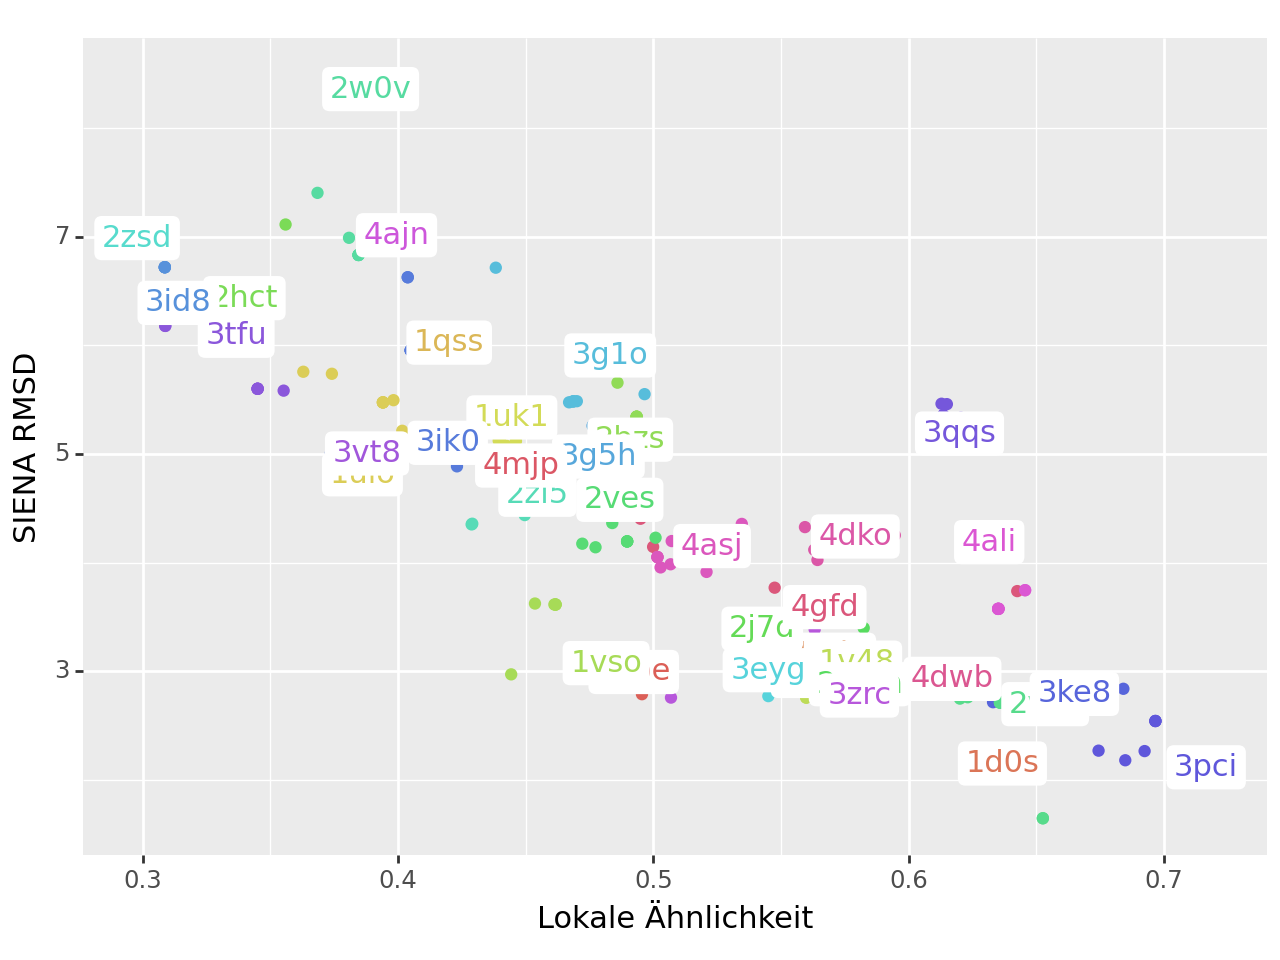

<Figure Size: (640 x 480)>

In [523]:
(ggplot(data=data,
        mapping=aes(x='local_similarity', y='siena_rmsd', colour='name',
                    label='name'))
 + geom_point()
 + geom_label(data=data.groupby('name').first().reset_index(),
              boxcolor=(1, 1, 1, 0))
 + scale_color_discrete(guide=False)
 + labs(x=lookup_de_name('local_similarity'), y=lookup_de_name('siena_rmsd'))
 )


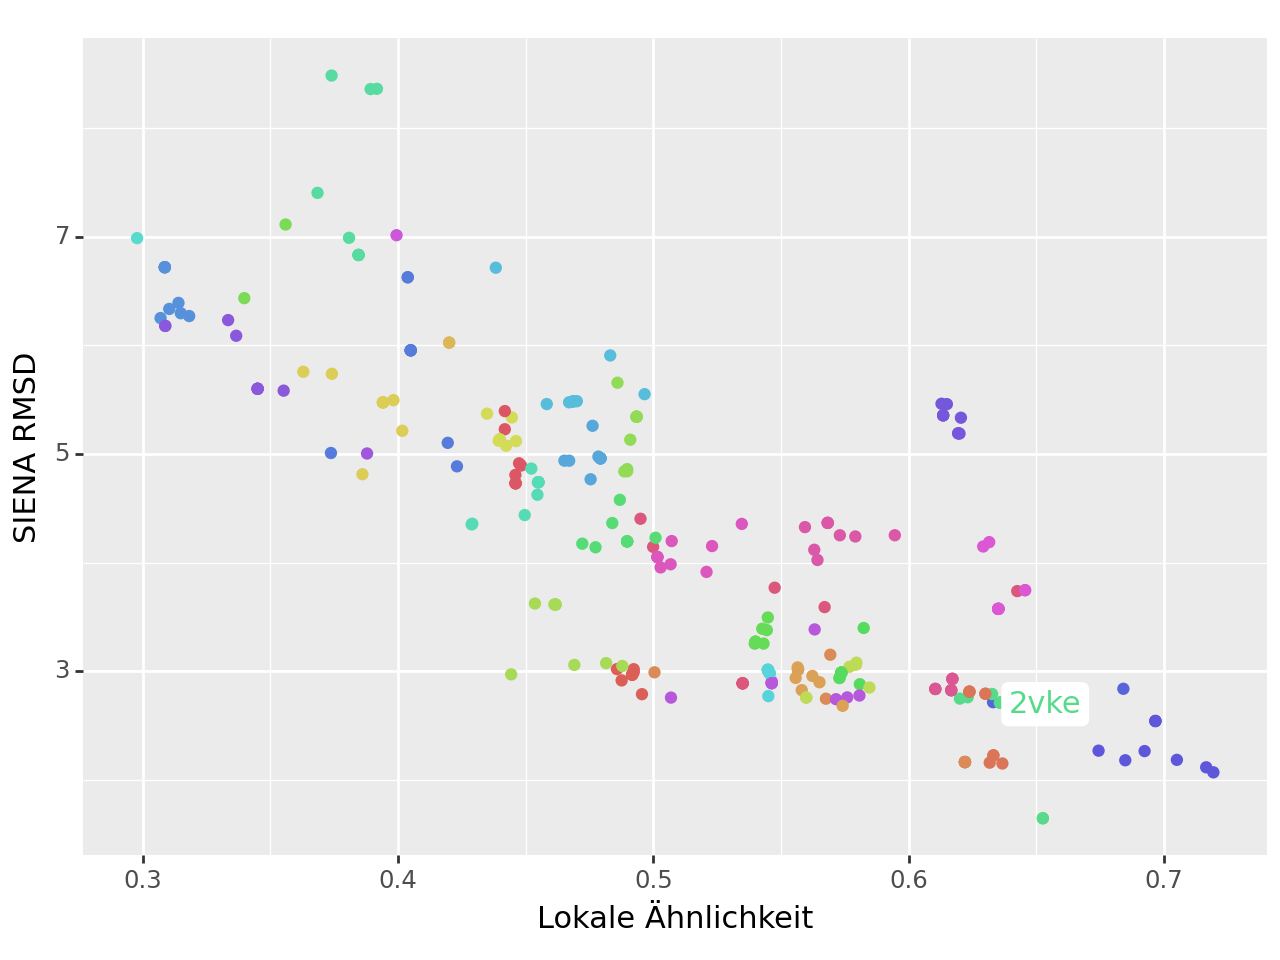

<Figure Size: (640 x 480)>

In [524]:
(ggplot(data=data, mapping=aes(x='local_similarity', y='siena_rmsd', colour='name',
                    label='name'))
 + geom_point()
 + geom_label(data=data.loc[data['name'] == '2vke'].groupby('name').first().reset_index(), boxcolor=(1, 1, 1, 0))
 + scale_color_discrete(guide=False)
 + labs(x=lookup_de_name('local_similarity'), y=lookup_de_name('siena_rmsd'))
 )



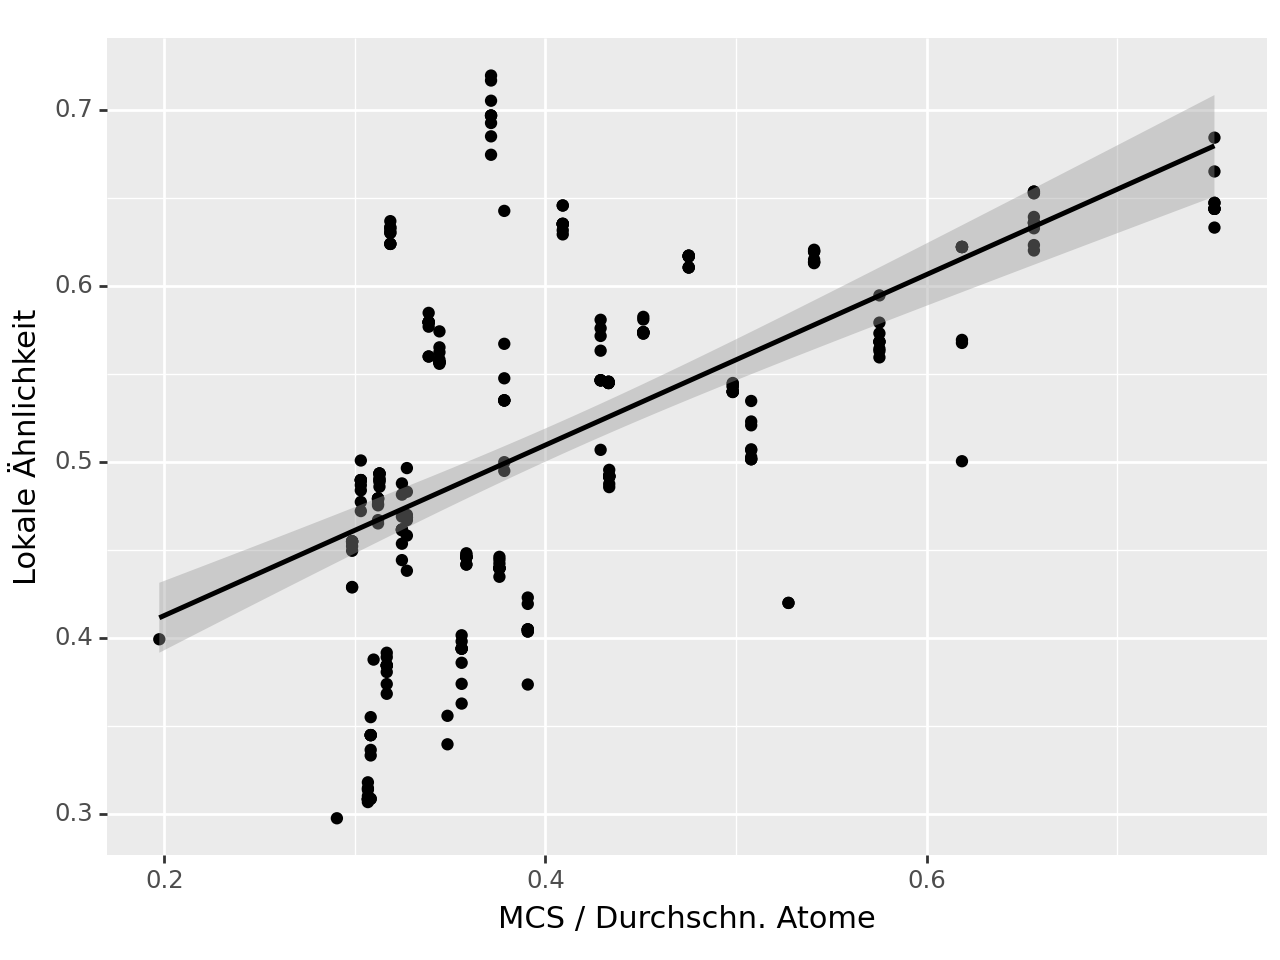

<Figure Size: (640 x 480)>

In [525]:
(ggplot(data=data, mapping=aes(x='mcs_size_to_atom_size', y='local_similarity'))
 + geom_point()
 + geom_smooth(method='lm')
 + labs(x=lookup_de_name('mcs_size_to_atom_size'), y=lookup_de_name('local_similarity'))
 )

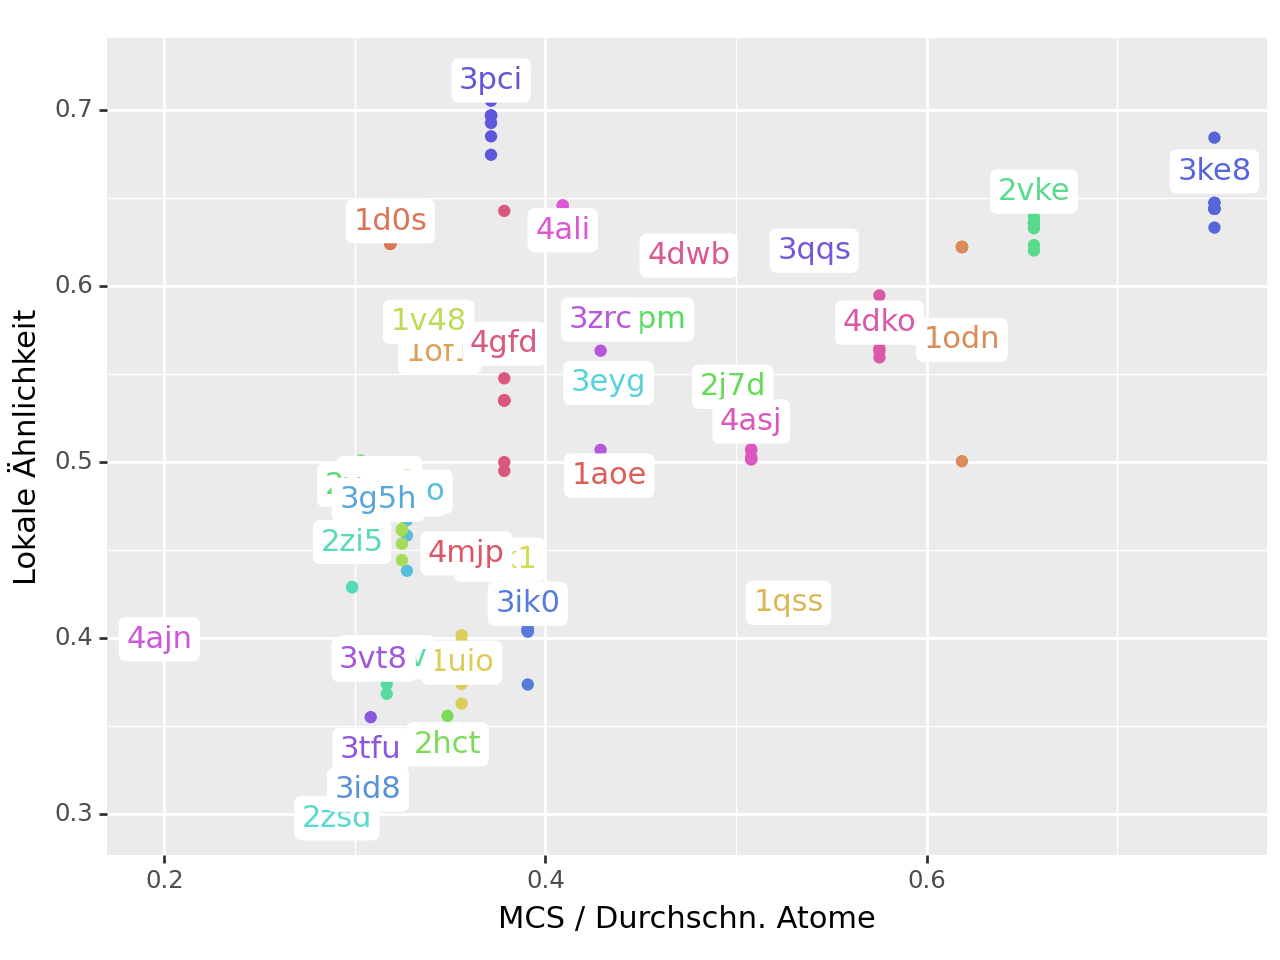

<Figure Size: (640 x 480)>

In [526]:
(ggplot(data=data, mapping=aes(x='mcs_size_to_atom_size', y='local_similarity',
                               colour='name', label='name'))
 + geom_point()
 + geom_label(data=data.groupby('name').first().reset_index(), boxcolor=(1, 1, 1, 0))
 + scale_color_discrete(guide=False)
 + labs(x=lookup_de_name('mcs_size_to_atom_size'), y=lookup_de_name('local_similarity'))
 )


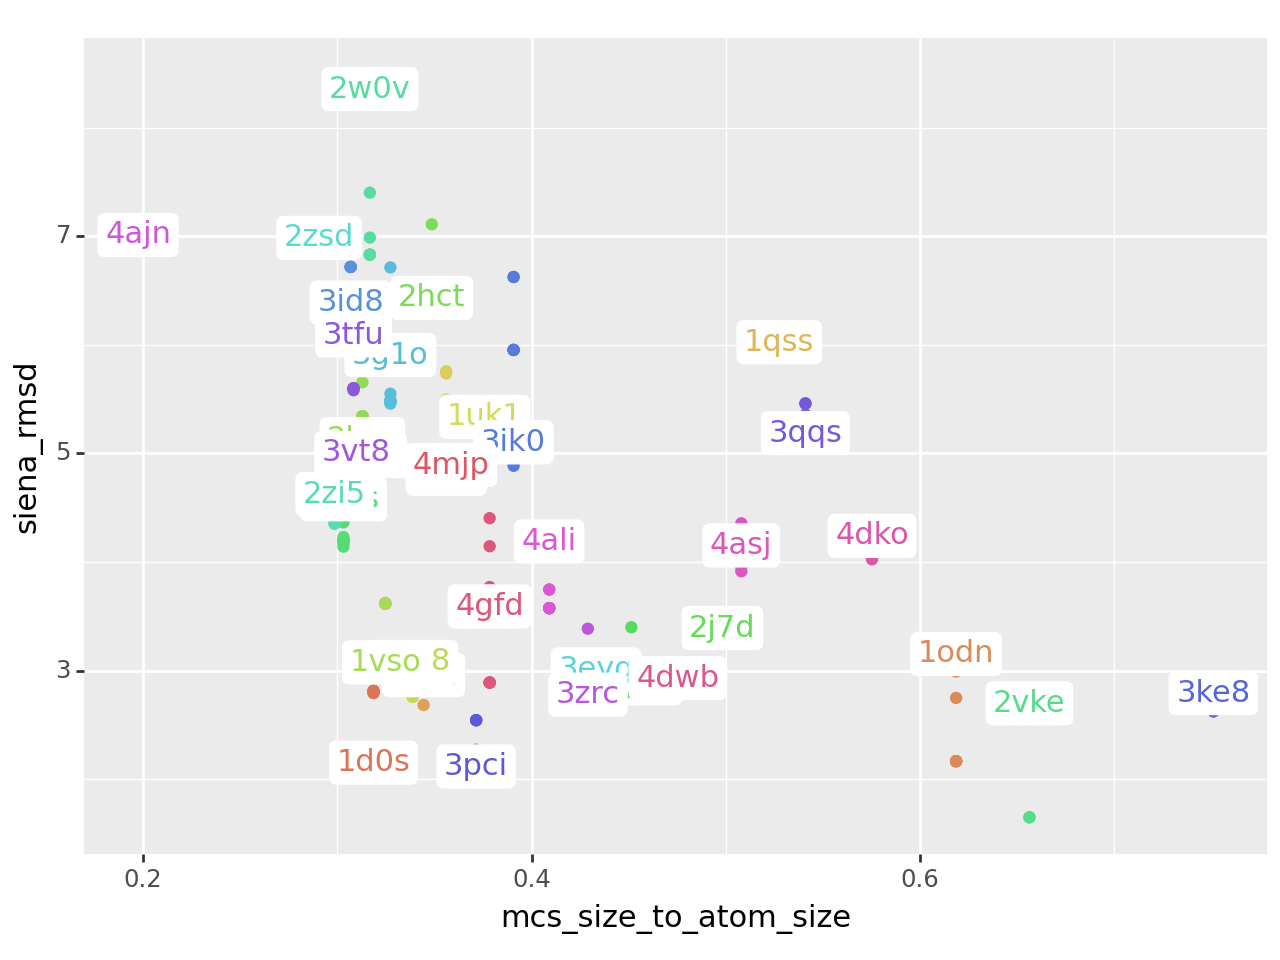

<Figure Size: (640 x 480)>

In [527]:
(ggplot(data=data,
        mapping=aes(x='mcs_size_to_atom_size', y='siena_rmsd', colour='name',
                    label='name'))
 + geom_point()
 + geom_label(data=data.groupby('name').first().reset_index(),
              boxcolor=(1, 1, 1, 0))
 + scale_color_discrete(guide=False)
 )


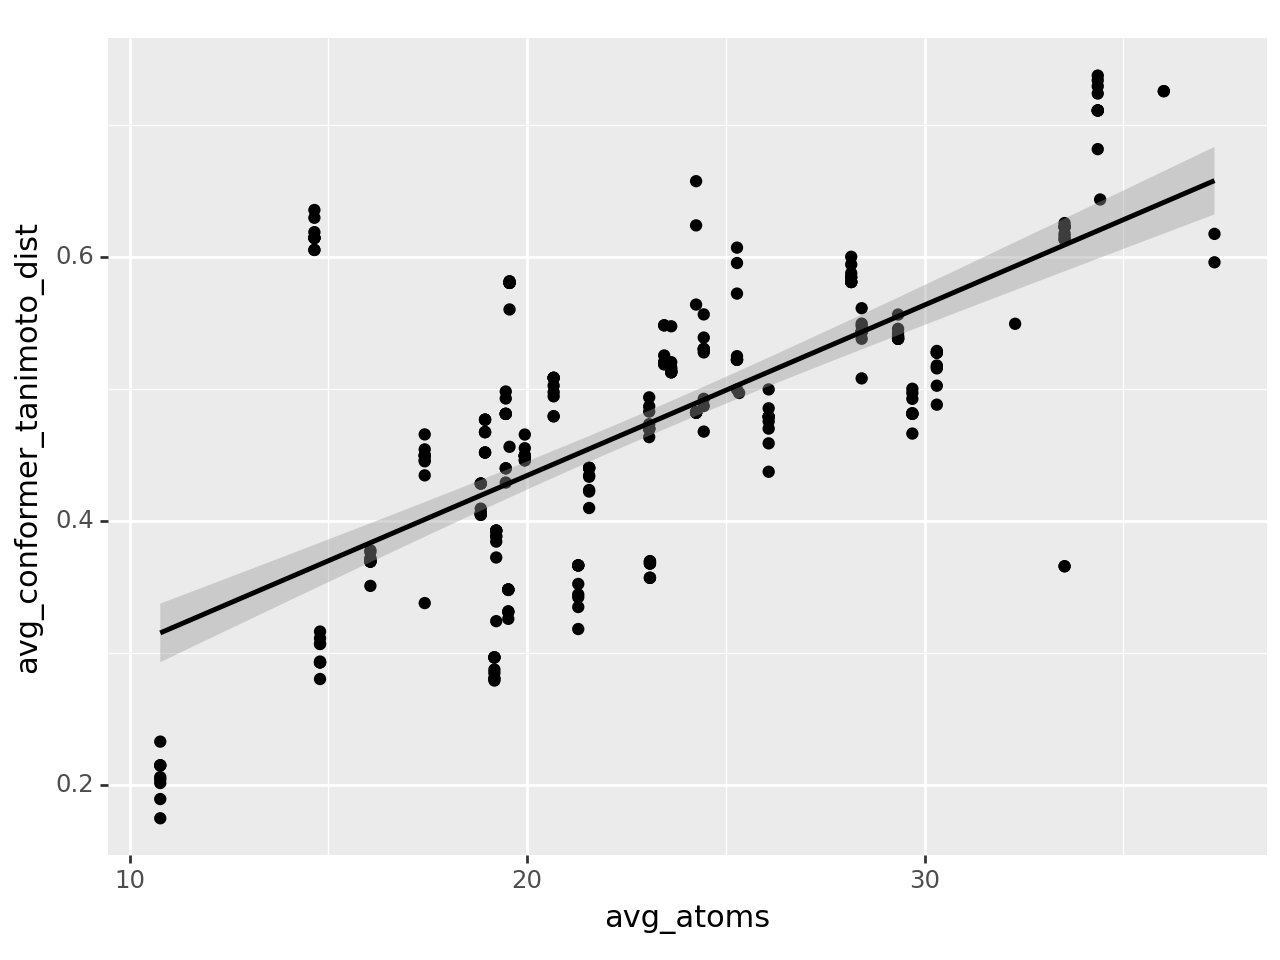

<Figure Size: (640 x 480)>

In [528]:
(ggplot(data=data, mapping=aes(x='avg_atoms', y='avg_conformer_tanimoto_dist'))
 + geom_point()
 + geom_smooth(method='lm'))

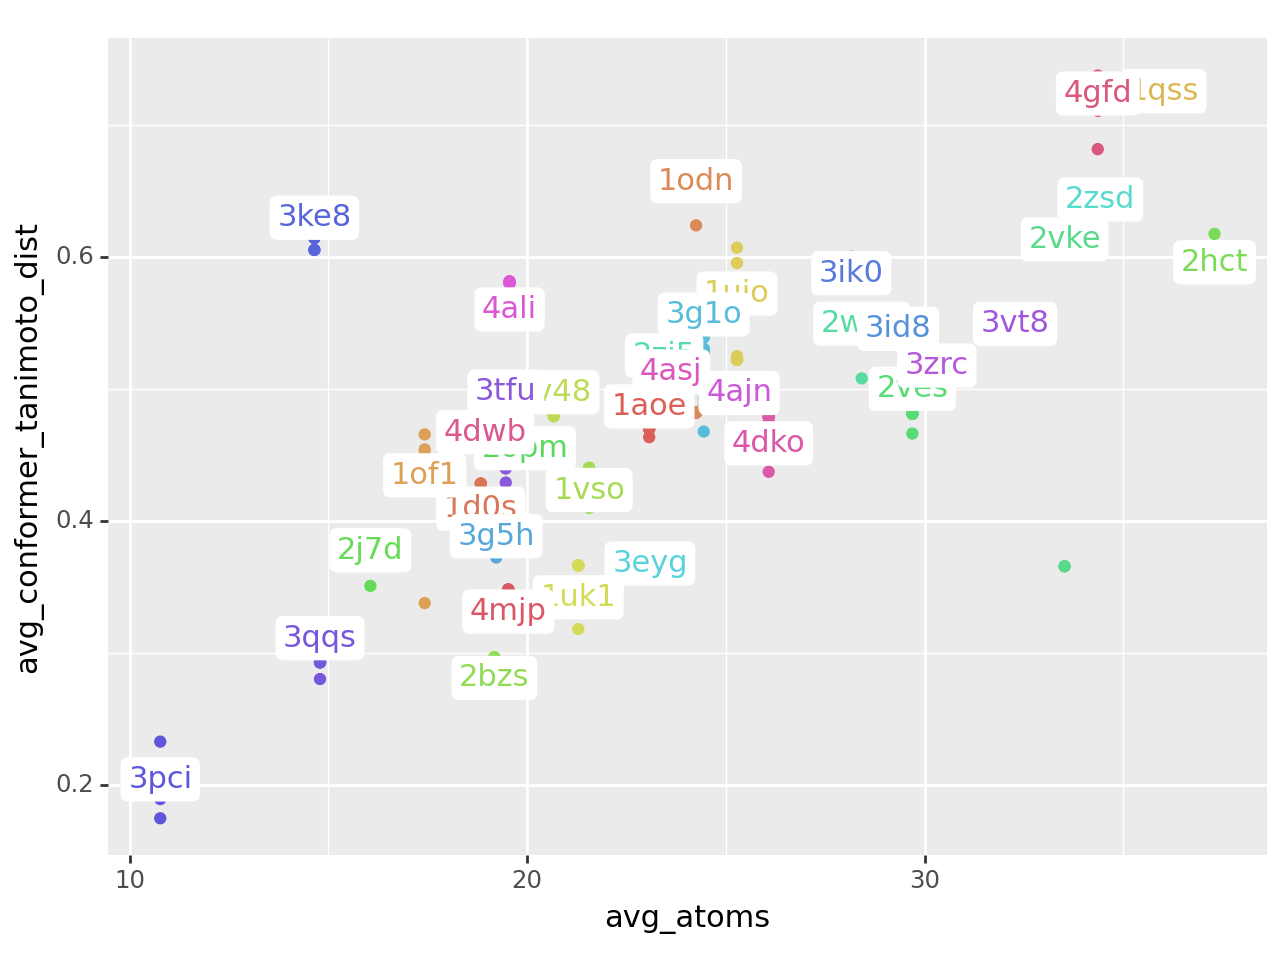

<Figure Size: (640 x 480)>

In [529]:
(ggplot(data=data, mapping=aes(x='avg_atoms', y='avg_conformer_tanimoto_dist',
                               colour='name', label='name'))
 + geom_point()
 + geom_label(data=data.groupby('name').first().reset_index(),
              boxcolor=(1, 1, 1, 0))
 + scale_color_discrete(guide=False)
 )


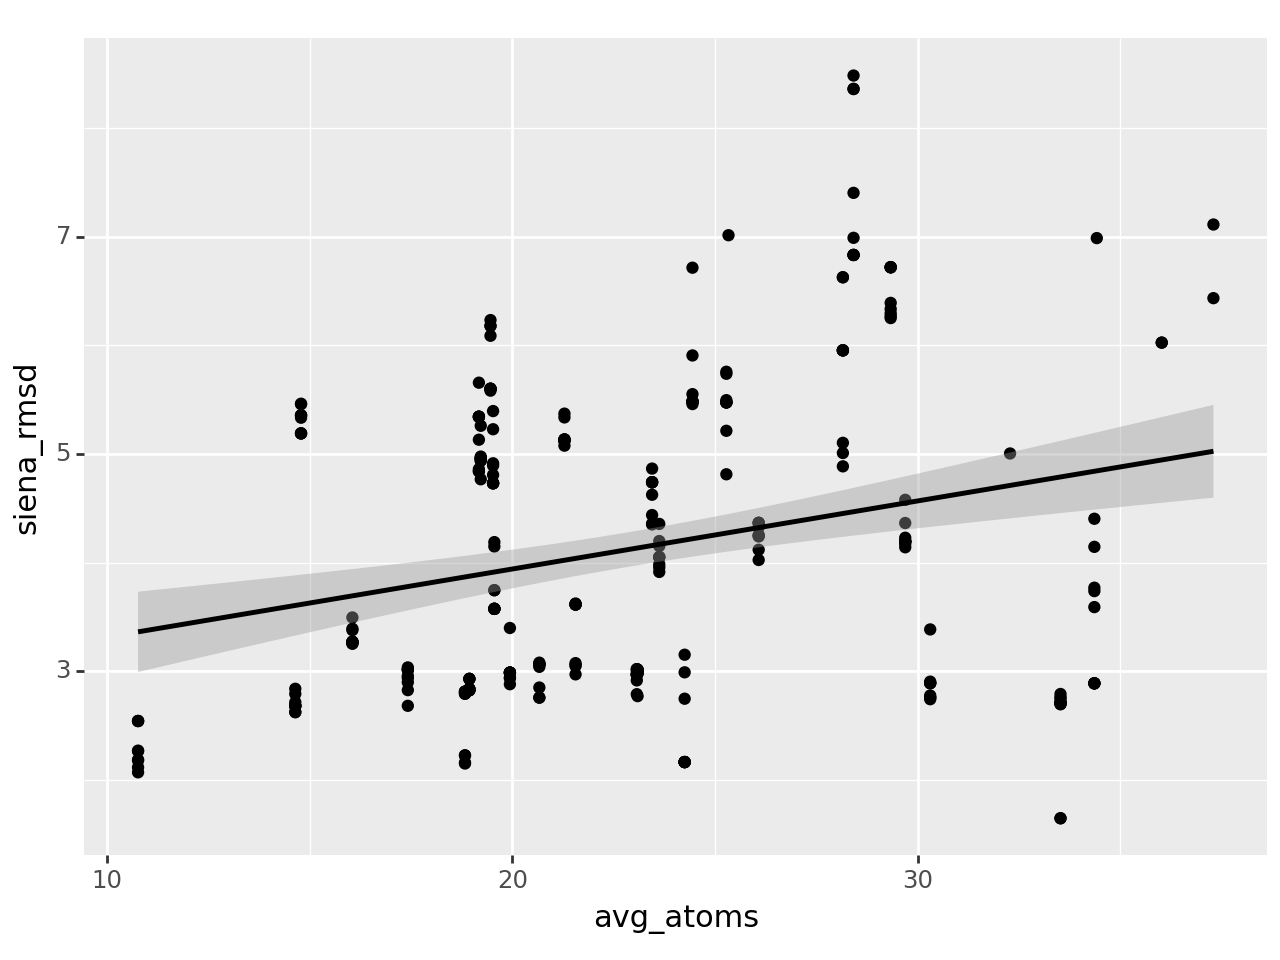

<Figure Size: (640 x 480)>

In [530]:
(ggplot(data=data, mapping=aes(x='avg_atoms', y='siena_rmsd'))
 + geom_point()
 + geom_smooth(method='lm'))

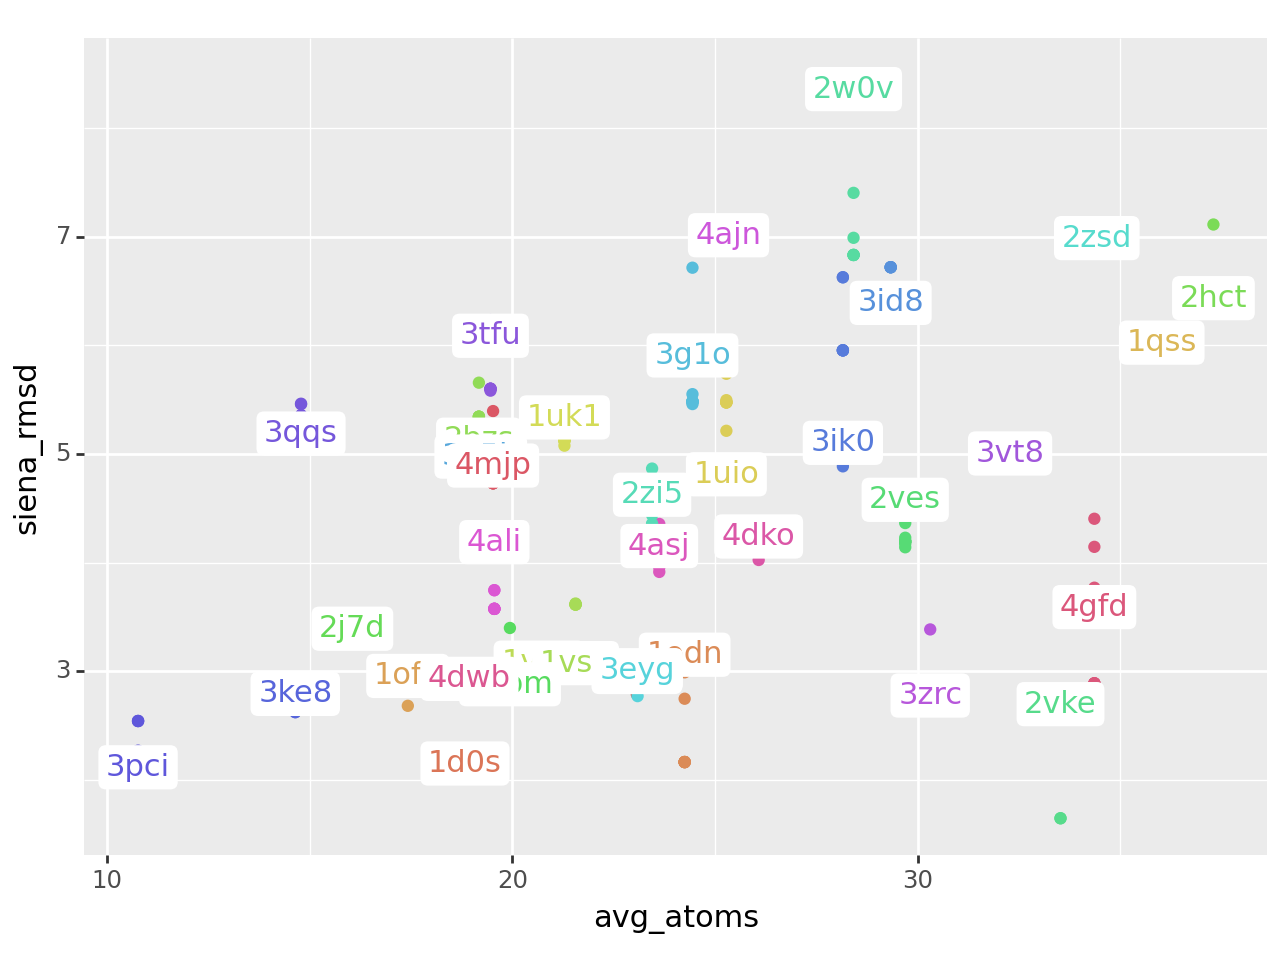

<Figure Size: (640 x 480)>

In [531]:
(ggplot(data=data,
        mapping=aes(x='avg_atoms', y='siena_rmsd', colour='name', label='name'))
 + geom_point()
 + geom_label(data=data.groupby('name').first().reset_index(),
              boxcolor=(1, 1, 1, 0))
 + scale_color_discrete(guide=False)
 )


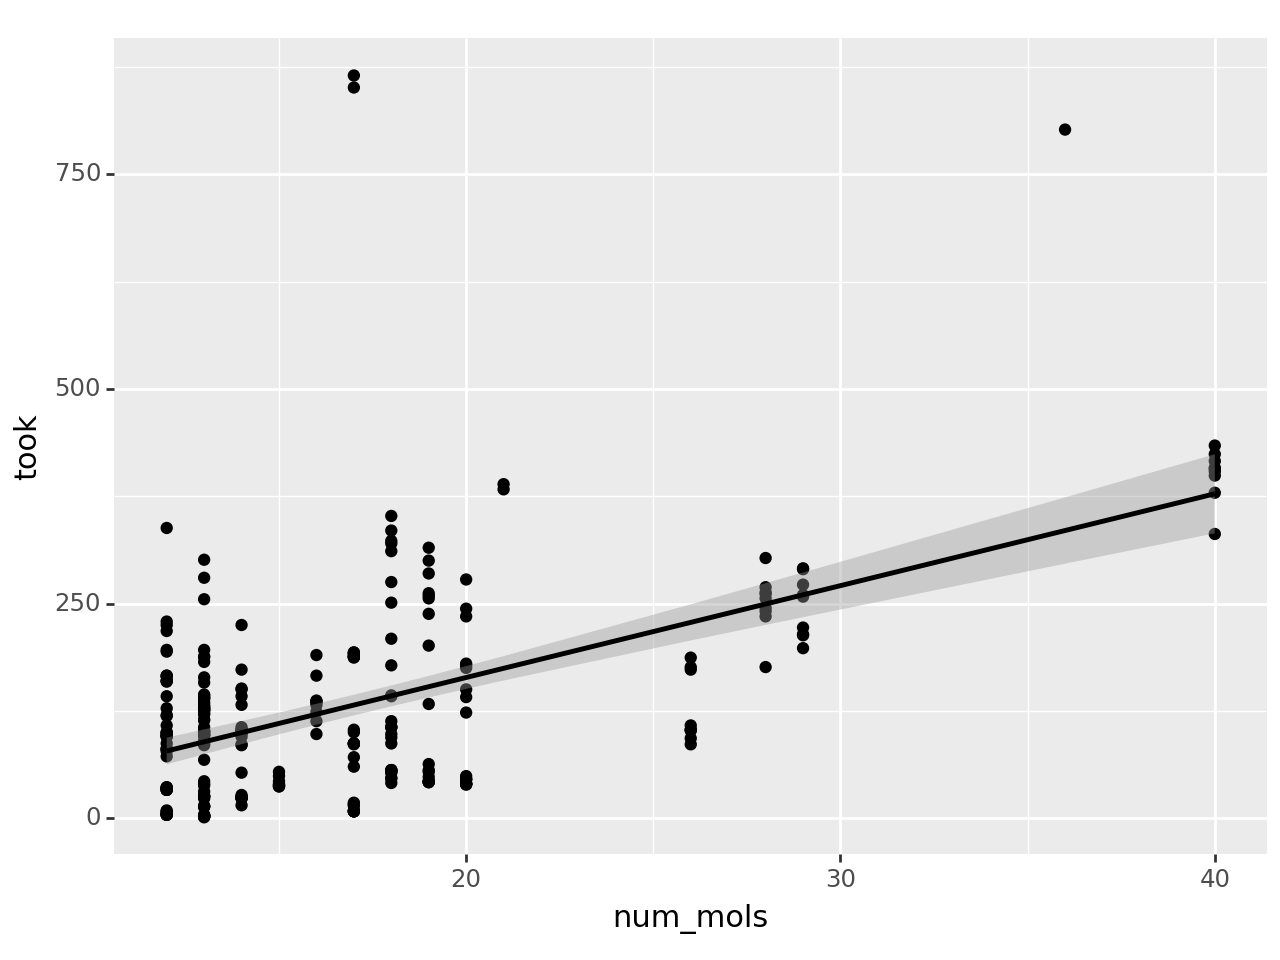

<Figure Size: (640 x 480)>

In [532]:
(ggplot(data=data, mapping=aes(x='num_mols', y='took'))
 + geom_point()
 + geom_smooth(method='lm'))

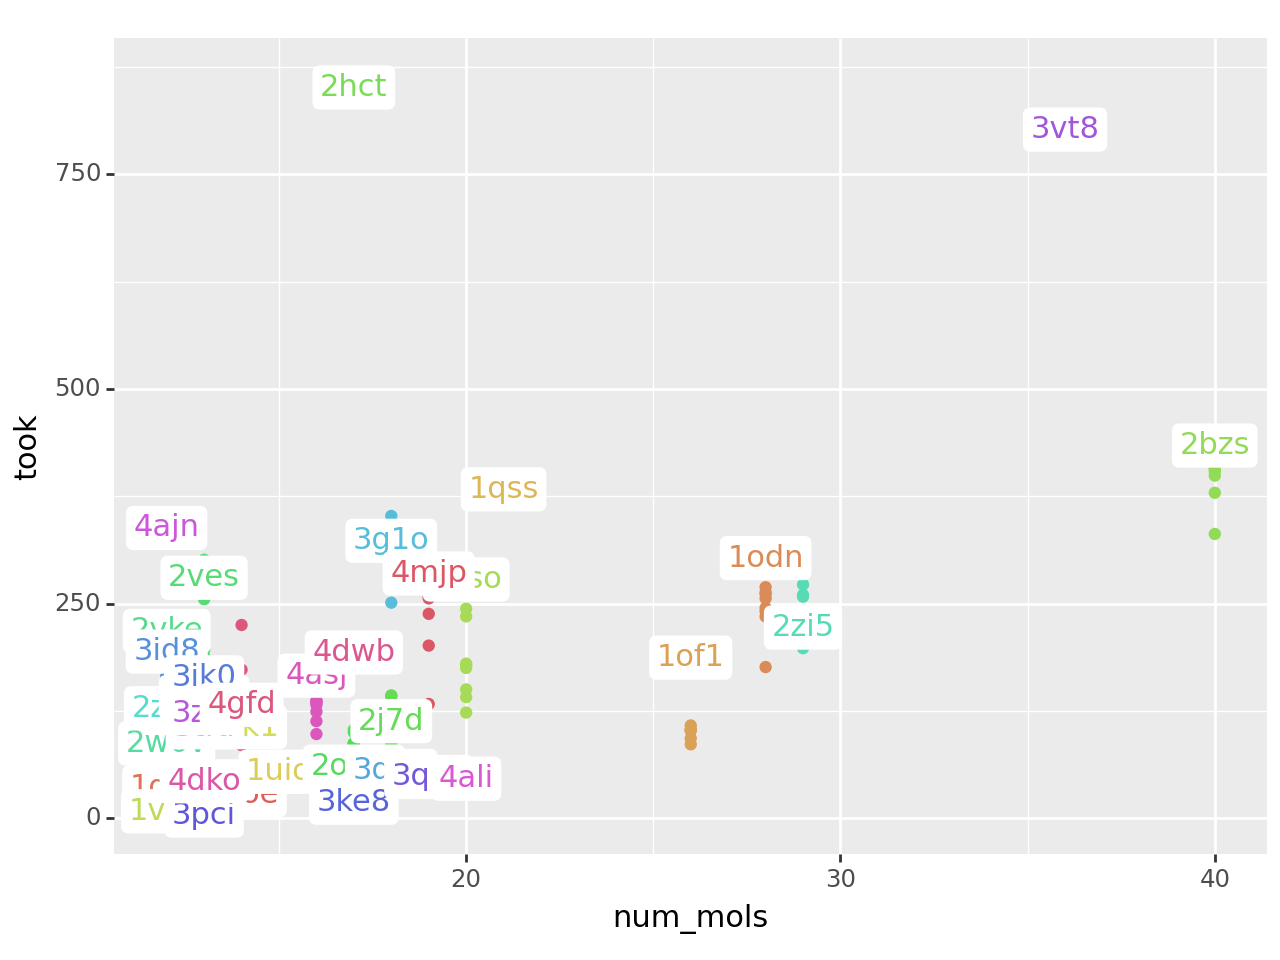

<Figure Size: (640 x 480)>

In [533]:
(ggplot(data=data,
        mapping=aes(x='num_mols', y='took', colour='name', label='name'))
 + geom_point()
 + geom_label(data=data.groupby('name').first().reset_index(),
              boxcolor=(1, 1, 1, 0))
 + scale_color_discrete(guide=False)
 )